# Imports

In [1]:
import pandas as pd
from scipy.stats import pearsonr
import datetime

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import holidays

from prophet import Prophet
import math
from sklearn.metrics import mean_squared_error

from typing import Optional, Any, Tuple, List

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# Preprocessing functions

In [6]:
def read_processed_data() -> pd.DataFrame:
    df = pd.read_csv('final_data_daily.csv')  # Load CSV
    df['datetime'] = pd.to_datetime(df['Date'])  # Convert 'Date' column
    df.drop(columns=['Date'], inplace=True)  # Remove 'Date' column (optional)
    df.drop_duplicates(subset=['datetime'], keep='first', inplace=True)  # Remove duplicate timestamps
    return df


# Run and save preprocessing

In [7]:
def preprocess_and_save(known_features_list: list, n_days_lag: int, rerun: bool):
  df = read_processed_data()
  df['winterIndex'] = df[['Year_y', 'Month']].apply(lambda x: reindex_winter_years(x.Year_y, x.Month), axis=1)
  df.drop(columns=['Year_y', 'Month'], inplace=True)  # Drop after usage

  df['datetime'] = pd.to_datetime(df['datetime'])
  
  train_test_indices = set_train_test_indices(df)
  numerical_columns = find_numerical_columns(df)

  if rerun:
    fold = 1
    for train_indices, test_index in train_test_indices:
      print(train_indices, test_index)
      df_tmp = df.copy()

      df_tmp['train'] = df_tmp['winterIndex'].apply(lambda x: True if x in train_indices else False)
      df_tmp['test'] = df_tmp['winterIndex'].apply(lambda x: True if x == test_index else False)

      df_tmp = clear_outliers(df_tmp, numerical_columns)

      df_lag = shift_data(df_tmp, n_days_lag, known_features_list=known_features_list)

      df_train_val, df_test = split_train_val_test(df_lag)

      if len(df_train_val) > 0:
        df_train_val, df_test, numerical_columns_lagged = impute_numerical_columns(
          df_train_val=df_train_val,
          df_test=df_test,
          numerical_columns=numerical_columns,
          n_days_lag=n_days_lag,
          known_features_list=known_features_list
        )

        df_train_val.to_csv(f'train_fold{fold}.csv')
        df_test.to_csv(f'test_fold{fold}.csv')

      fold += 1

  return train_test_indices, numerical_columns

In [ ]:
def reindex_winter_years(year, month):
    """
    Adjusts the year to align with the winter season.
    Typically, the winter season extends from December to February.
    This function ensures that the winter season falls within a single indexed year.
    
    Args:
        year (int): The year of the record.
        month (int): The month of the record.
    
    Returns:
        int: Adjusted winter season index.
    """
    if month in [12]:  # December belongs to the next year's winter
        return year + 1
    else:  # January and February belong to the current year
        return year


# Set parameters

In [8]:
known_features_list = ['winterIndex', 'train', 'test']
n_days_lag=60

train_test_indices, numerical_columns = preprocess_and_save(known_features_list, n_days_lag, rerun=False)

numerical_columns_lagged = [f"{i}-{n_days_lag}days" for i in numerical_columns if i != 'winterIndex']

n_predictors = 5
alpha = 0.05
use_all_predictors = True
include_price_bool = False
include_climate_change_bool = False
use_no_predictors = False
huang = True
tan = False

NameError: name 'reindex_winter_years' is not defined

In [ ]:
numerical_columns

In [ ]:
train_test_indices

# Prophet

In [ ]:
def prepare_data_for_prophet(
    df: pd.DataFrame,
    predictors_list: list,
    use_all_predictors: bool,
    use_no_predictors: bool,
    n_days_lag: int,
    ) -> pd.DataFrame:
  """Select the predictors from the df and rename date to ds and load to y."""

  if use_all_predictors:
    print("All predictors are used")
    df_prophet = df.copy()

  if use_no_predictors:
    print("No predictors are used")
    cols_to_select = predictors_list.copy()
    cols_to_select.append('datetime')
    cols_to_select.append('DailyLoadConsumption')
    df_prophet = df[cols_to_select]

  df_prophet.rename(columns={'datetime':'ds', 'DailyLoadConsumption':'y'}, inplace=True)

  return df_prophet


def initialize_prophet(
    regressors: list,
    ):
    """
    Initialize prophet. Either with specified seasonalities or default.
    Add regressors if any are entered.
    """
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
    )

    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)

    return model


def combine_prophet_predictions_and_target(prophet_forecast, df_subset, prophet_columns_to_select, predictors_to_select):
  """
  Combine the results from Prophet with the target LoadConsumption.
  """
  df_subset['ds'] = pd.to_datetime(df_subset['ds'], format='%Y-%m-%d %H:%M:%S')
  new_predictors_to_select = predictors_to_select + ['y', 'ds'] #, 'seasonal', 'trend']
  df_subset = df_subset[new_predictors_to_select]
  prophet_forecast = prophet_forecast[prophet_columns_to_select]

  df_prophet = prophet_forecast.merge(df_subset, on='ds', how='left')
  df_prophet.rename(columns={'y':'DailyLoadConsumption'}, inplace=True)

  return df_prophet

In [ ]:
def reload_data(fold: int):
  df_train_val = pd.read_csv(f'train_val_fold{fold}.csv').drop(columns=['Unnamed: 0'])
  df_test = pd.read_csv(f'test_fold{fold}.csv').drop(columns=['Unnamed: 0'])

  return df_train_val, df_test


def predictor_selection(
    df_train_val: pd.DataFrame,
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    n_days_lag: int,
    use_all_predictors: bool,
    use_no_predictors: bool,
    include_climate_change_bool: bool,
    include_price_bool: bool,
    known_features_list: list):

  if use_all_predictors:
    predictors_list = list(df_train_val.columns)
    predictors_list.remove('datetime')
    predictors_list.remove('DailyLoadConsumption')
    if include_price_bool:
      predictors_list.remove(f'avgGasPrice-{n_days_lag}days')
      predictors_list.remove(f'avgElectricityPrice-{n_days_lag}days')
    if include_climate_change_bool:
      predictors_list.remove(f'dailyPrecipitation-{n_days_lag}days')
      predictors_list.remove(f'dailyMeanTemperature-{n_days_lag}days')
      predictors_list.remove(f'dailyMeanWindspeed-{n_days_lag}days')
      predictors_list.remove(f'NAO-{n_days_lag}days')
      predictors_list.remove(f'nat-{n_days_lag}days')
      predictors_list.remove(f'sic-{n_days_lag}days')
      predictors_list.remove(f'geopotential-{n_days_lag}days')

  else:
    predictors_list = [
      f'loadConsumption-{n_days_lag}days',
      f"loadConsumption-{n_days_lag}days-24h",
      f"loadConsumption-{n_days_lag}days-7days",
      f"loadConsumption-{n_days_lag}days-12m"
    ]

    if include_price_bool:
      price_columns=[
      f'avgGasPrice-{n_days_lag}days',
      f'avgElectricityPrice-{n_days_lag}days',
      ]

      predictors_list = predictors_list + price_columns
    if include_climate_change_bool:
      climate_change_columns=[
      f'dailyPrecipitation-{n_days_lag}days',
      f'dailyMeanTemperature-{n_days_lag}days',
      f'dailyMeanWindspeed-{n_days_lag}days',
      f'NAO-{n_days_lag}days',
      f'nat-{n_days_lag}days',
      f'sic-{n_days_lag}days',
      f'geopotential-{n_days_lag}days'
      ]

      predictors_list = predictors_list + climate_change_columns

  predictors_list = list(set(predictors_list))

  return predictors_list


In [ ]:
def run_prophet(
      df_train_val: pd.DataFrame,
      df_test: pd.DataFrame,
      predictors_list: list,
      use_all_predictors: bool,
      use_no_predictors: bool,
      n_days_lag: bool
    ):

  df_train_prophet = prepare_data_for_prophet(
      df=df_train_val,
      predictors_list=predictors_list,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  df_test_prophet = prepare_data_for_prophet(
      df=df_test,
      predictors_list=predictors_list,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  model = initialize_prophet(regressors=predictors_list)
  model.fit(df_train_prophet)
  predictions_train_validation = model.predict(df_train_prophet)
  predictions_wintertime = model.predict(df_test_prophet)

  df_train_lstm = combine_prophet_predictions_and_target(
    prophet_forecast=predictions_train_validation,
    df_subset=df_train_prophet,
    prophet_columns_to_select=['yhat', 'ds', 'trend', 'daily', 'weekly', 'yearly'],
    predictors_to_select=predictors_list
  )

  df_test_lstm = combine_prophet_predictions_and_target(
    prophet_forecast=predictions_wintertime,
    df_subset=df_test_prophet,
    prophet_columns_to_select=['yhat', 'ds', 'trend', 'daily', 'weekly', 'yearly'],
    predictors_to_select=predictors_list
  )

  return df_train_lstm, df_test_lstm


# Save individual prophet forecasts

In [ ]:
def save_prophet_forecasts(
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    use_all_predictors: bool,
    include_price_bool: bool,
    include_climate_change_bool: bool,
    use_no_predictors: bool,
    train_test_indices: list,
    folder_name: str,
    n_days_lag: int):

    for fold in range(3, 11, 1):
        print(f"FOLD {fold}")
        df_train_val, df_test  = reload_data(fold)
        predictors_list = predictor_selection(
            df_train_val,
            numerical_columns_lagged,
            n_predictors,
            alpha,
            n_days_lag,
            use_all_predictors,
            use_no_predictors,
            include_climate_change_bool,
            include_price_bool,
            known_features_list
        )

        df_train_lstm, df_test_lstm = run_prophet(
            df_train_val,
            df_test,
            predictors_list,
            use_all_predictors,
            use_no_predictors,
            n_days_lag
        )

        df_train_lstm.to_csv(f'prophet_forecasts/{folder_name}tainfold{fold}.csv')
        df_test_lstm.to_csv(f'prophet_forecasts/{folder_name}/testfold{fold}.csv')


### All predictors

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name = 'all_predictors',
    n_days_lag = 60
)

### No predictors

In [81]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors',
     n_days_lag = 60

)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### All predictors - price

In [84]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=True,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_price',
     n_days_lag = 60

)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### No predictors + price

In [86]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=True,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_price',
     n_days_lag = 60

)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### All predictors - climate change

In [87]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_climate_change',
     n_days_lag = 60

)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### No predictors + climate change

In [88]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_climate_change',
     n_days_lag = 60

)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

# LSTM

In [89]:
def choose_model_setup(huang: bool, tan: bool, train_X):
  if huang:
    model = Sequential()
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='relu', return_sequences=True, name='LSTM_layer_1'))
    model.add(LSTM(90, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
  if tan:
    model = Sequential()
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
    model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
    model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
    model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
    model.add(Dense(1, activation='linear', name='Dense_Layer'))
    model.compile(optimizer='rmsprop', loss='mse')
  return model


def fit_model(model, train_X, train_y, test_X, test_y, epochs, batch_size):
  """
  Fit model and show plot of training process.
  """
  callback = EarlyStopping(monitor='val_loss',patience=3, start_from_epoch=8, min_delta=0.0001)
  history = model.fit(
      train_X,
      train_y,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(test_X, test_y),
      verbose=2,
      shuffle=False,
      callbacks=[callback]
  )

  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  return model

def inverse_transform_predictions(scaler, data, colName, colNames):
  dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
  dummy[colName] = data
  dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
  return dummy[colName].values


def predict(model, test_X, scaler, df):
  """Make predictions and inverse them to scale them back"""

  yhat = model.predict(test_X)
  yhat_inversed = inverse_transform_predictions(scaler=scaler, data=yhat, colName='loadConsumption_scaled', colNames=df.columns)

  return yhat, yhat_inversed

def evaluate_predictions(test_y, yhat_inversed, scaler, df):
  test_y_inversed = inverse_transform_predictions(scaler=scaler, data=test_y, colName='loadConsumption_scaled', colNames=df.columns)

  mape = np.mean(np.abs((test_y_inversed - yhat_inversed) / test_y_inversed)) * 100
  rmse = np.sqrt(mean_squared_error(test_y_inversed, yhat_inversed))
  corr_test, p_value_test = pearsonr(test_y_inversed, yhat_inversed)
  print(f'MAPE: {mape}')
  print(f'RMSE: {rmse}')
  print(f'Correlation {corr_test} with p-value {p_value_test}')

  return mape, rmse, corr_test, p_value_test, test_y_inversed


def evaluate_wintertime_predictions(df_test, test_y_inversed, yhat_inversed):
  df_test['test_y'] = test_y_inversed
  df_test['forecasted_y'] = yhat_inversed
  df_test['month'] = df_test['ds'].dt.month

  df_winter_test = df_test[df_test['month'].isin([1, 2, 12])]
  actual = df_winter_test['test_y'].values
  forecast = df_winter_test['forecasted_y'].values

  mape = np.mean(np.abs((actual - forecast) / actual)) * 100
  rmse = np.sqrt(mean_squared_error(actual, forecast))
  corr_test, p_value_test = pearsonr(actual, forecast)

  return rmse, mape, corr_test, df_winter_test


def print_evaluation(
    rmse_list,
    mape_list,
    corr_list,
    wintertime_rmse_list,
    wintertime_mape_list,
    wintertime_corr_list):
  avg_rmse = round(sum(rmse_list) / len(rmse_list), 2)
  avg_corr = round(sum(corr_list) / len(corr_list), 2)
  avg_mape = round(sum(mape_list) / len(mape_list), 2)
  avg_rmse_wintertime = round(sum(wintertime_rmse_list) / len(wintertime_rmse_list), 2)
  avg_corr_wintertime = round(sum(wintertime_corr_list) / len(wintertime_corr_list), 2)
  avg_mape_wintertime = round(sum(wintertime_mape_list) / len(wintertime_mape_list), 2)

  print("AVG")
  print('----------------------------------')
  print(f"{avg_rmse} & {avg_mape} & {avg_corr} & {avg_rmse_wintertime} & {avg_mape_wintertime} & {avg_corr_wintertime} ")
  print('----------------------------------')
  print("GENERAL FOLDS")
  print('----------------------------------')
  for i in range(len(rmse_list)):
    print(f"{round(rmse_list[i], 2)} & {round(mape_list[i], 2)} & {round(corr_list[i], 2)}")
  print('----------------------------------')
  print("WINTERTIME FOLDS")
  print('----------------------------------')
  for i in range(len(wintertime_rmse_list)):
    print(f"{round(wintertime_rmse_list[i], 2)} & {round(wintertime_mape_list[i], 2)} & {round(wintertime_corr_list[i], 2)}")



def run_lstm(
    df_train_lstm: pd.DataFrame,
    df_test_lstm: pd.DataFrame,
    huang: bool,
    tan: bool):

  # sort values and set index
  df_train_lstm = df_train_lstm.sort_values(by='ds')
  df_train_lstm.set_index('ds', inplace=True)
  df_test = df_test_lstm.sort_values(by='ds')
  df_test.set_index('ds', inplace=True)

  # min max scaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_scaled = scaler.fit_transform(df_train_lstm)
  df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_lstm.columns])

  df_test = df_test[df_train_lstm.columns]
  test_scaled = scaler.transform(df_test)
  df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_test.columns])

  # reorder columns
  cols_ordered = list(df_train_scaled)
  cols_ordered.remove('loadConsumption_scaled')
  cols_ordered.append('loadConsumption_scaled')
  df_train_scaled = df_train_scaled[cols_ordered]
  df_test_scaled = df_test_scaled[cols_ordered]

  # split into X and y
  train_values = df_train_scaled.values
  test_values = df_test_scaled.values

  train_X, train_y = train_values[:, :-1], train_values[:, -1]
  test_X, test_y = test_values[:, :-1], test_values[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print(len(train_X), len(test_X))
  print("shape", train_X.shape[1], train_X.shape[2])

  # fit, predict and evaluate
  model = choose_model_setup(huang, tan, train_X)
  model = fit_model(model, train_X, train_y, test_X, test_y, epochs=50, batch_size=128)
  yhat, yhat_inversed = predict(model, test_X, scaler, df=df_train_scaled)
  mape, rmse, corr_test, p_value, test_y_inversed = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)
  rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = evaluate_wintertime_predictions(df_test_lstm, test_y_inversed, yhat_inversed)

  return rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test

# Run in CV

In [90]:
def run_cv(
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    use_all_predictors: bool,
    include_price_bool: bool,
    include_climate_change_bool: bool,
    use_no_predictors: bool,
    huang: bool,
    tan: bool,
    train_test_indices: list,
    folder_name: str):

    fold = 3
    rmse_list = []
    corr_list = []
    mape_list = []

    wintertime_rmse_list = []
    wintertime_corr_list = []
    wintertime_mape_list = []

    for fold in range (3, 11, 1):
      if fold <= 10:
        print(f"FOLD {fold}")
        df_train_val, df_test  = reload_data(fold)
        predictors_list = predictor_selection(
            df_train_val,
            numerical_columns_lagged,
            n_predictors,
            alpha,
            n_days_lag,
            use_all_predictors,
            use_no_predictors,
            include_climate_change_bool,
            include_price_bool,
            known_features_list
        )

        df_train_lstm, df_test_lstm = run_prophet(
            df_train_val,
            df_test,
            predictors_list,
            use_all_predictors,
            use_no_predictors,
            n_days_lag
        )

        df_train_lstm = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/prophet_forecasts/{folder_name}/train/fold{fold}.csv').drop(columns=['Unnamed: 0'])
        df_test_lstm = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/prophet_forecasts/{folder_name}/test/fold{fold}.csv').drop(columns=['Unnamed: 0'])

        if use_all_predictors:
          df_train_lstm.drop(columns=['winterIndex', 'train', 'test'], inplace=True)
          df_test_lstm.drop(columns=['winterIndex', 'train', 'test'], inplace=True)

        df_train_lstm['ds'] = pd.to_datetime(df_train_lstm['ds'])
        df_test_lstm['ds'] = pd.to_datetime(df_test_lstm['ds'])

        rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = run_lstm(df_train_lstm, df_test_lstm, huang, tan)
        rmse_list.append(rmse)
        mape_list.append(mape)
        corr_list.append(corr_test)
        wintertime_rmse_list.append(rmse_wintertime)
        wintertime_mape_list.append(mape_wintertime)
        wintertime_corr_list.append(pcc_wintertime)

        fold += 1
        print('---------------')

    print_evaluation(
        rmse_list=rmse_list,
        mape_list=mape_list,
        corr_list=corr_list,
        wintertime_rmse_list=wintertime_rmse_list,
        wintertime_mape_list=wintertime_mape_list,
        wintertime_corr_list=wintertime_corr_list
    )

    return rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list

# Huang

### All predictors

In [91]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### No predictors

In [92]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

# Tan

### All predictors

In [93]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### No predictors

In [94]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors'
    )

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

# With/without price

### Tan ALL

In [95]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_price'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Tan None

In [96]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_price'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Huang ALL

In [97]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_price'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Huang NONE

In [98]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_price'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

# Climate change

### Tan ALL

In [99]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_climate_change'
)

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Tan NONE

In [100]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_climate_change')

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Huang ALL

In [101]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_climate_change')

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Huang None

In [102]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_climate_change')

FOLD 3


FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### Impact of individual climate change predictors

In [103]:
climate_features = [
      f'dailyPrecipitation-{n_days_lag}days',
      f'dailyMeanTemperature-{n_days_lag}days',
      f'dailyMeanWindspeed-{n_days_lag}days',
      f'NAO-{n_days_lag}days',
      f'nat-{n_days_lag}days',
      f'sic-{n_days_lag}days',
      f'geopotential-{n_days_lag}days',
      f'renewableEnergyRatio-{n_days_lag}days'
      ]

In [104]:
def predictor_selection(
    df_train_val: pd.DataFrame,
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    n_days_lag: int,
    use_all_predictors: bool,
    use_no_predictors: bool,
    include_climate_change_bool: bool,
    include_price_bool: bool,
    known_features_list: list,
    feature_to_include: str,
):

  if use_all_predictors:
    predictors_list = list(df_train_val.columns)
    predictors_list.remove('datetime')
    predictors_list.remove('loadConsumption')
    if feature_to_include:
      predictors_list.remove(feature_to_include)

  else:
    predictors_list = [
      f'loadConsumption-{n_days_lag}days',
      f"loadConsumption-{n_days_lag}days-24h",
      f"loadConsumption-{n_days_lag}days-7days",
      f"loadConsumption-{n_days_lag}days-12m"
    ]

    if feature_to_include:
      predictors_list.append(feature_to_include)


  predictors_list = list(set(predictors_list))

  return predictors_list

In [105]:
df = read_processed_data()
df['winterIndex'] = df[['Year', 'Month']].apply(lambda x: reindex_winter_years(x.Year, x.Month), axis=1)
df.drop(columns=['Year', 'Month'], inplace=True)
numerical_columns = find_numerical_columns(df)

train_indices = [i for i in range(3, 9, 1)]
test_indices = [9, 10]
print(train_indices, test_indices)

df['train'] = df['winterIndex'].apply(lambda x: True if x in train_indices else False)
df['test'] = df['winterIndex'].apply(lambda x: True if x in test_indices else False)

df = clear_outliers(df, numerical_columns)

df_lag = shift_data(df, n_days_lag, known_features_list=known_features_list)

df_train_val, df_test = split_train_val_test(df_lag)

df_train_val, df_test, numerical_columns_lagged = impute_numerical_columns(
  df_train_val=df_train_val,
  df_test=df_test,
  numerical_columns=numerical_columns,
  n_days_lag=n_days_lag,
  known_features_list=known_features_list
)

KeyError: "['Year'] not in index"

In [106]:
df_train_val.to_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv')
df_test.to_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/test.csv')

NameError: name 'df_train_val' is not defined

In [107]:
df_train_val = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv').drop(columns=['Unnamed: 0'])
df_test = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/test.csv').drop(columns=['Unnamed: 0'])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv'

In [108]:
use_all_predictors=False
use_no_predictors=True
include_climate_change_bool=False
include_price_bool=False
huang=True
tan=False


results = {}

for feature in climate_features:
  print(feature)
  predictors_list = predictor_selection(
    df_train_val,
    numerical_columns_lagged,
    n_predictors,
    alpha,
    n_days_lag,
    use_all_predictors,
    use_no_predictors,
    include_climate_change_bool,
    include_price_bool,
    known_features_list,
    feature_to_include=feature
  )

  df_train_lstm, df_test_lstm = run_prophet(
    df_train_val,
    df_test,
    predictors_list,
    use_all_predictors,
    use_no_predictors,
    n_days_lag
  )

  rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = run_lstm(df_train_lstm, df_test_lstm, huang, tan)
  results[feature] = [round(rmse, 2),
                      round(mape, 2),
                      round(corr_test, 2),
                      round(rmse_wintertime, 2),
                      round(mape_wintertime, 2),
                      round(pcc_wintertime, 2)]
  print(rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime)
  print('---------------')


dailyPrecipitation-60days


NameError: name 'df_train_val' is not defined

In [109]:
results

{}

In [110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_train_val = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv').drop(columns=['Unnamed: 0'])

# the independent variables set
X = df_train_val[climate_features]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv'

# MLR

In [111]:
from sklearn.linear_model import LinearRegression


def evaluate_wintertime_predictions_mlr(df_test, test_y_inversed, yhat_inversed):
  df_test.reset_index(inplace=True)
  df_test['datetime'] = pd.to_datetime(df_test['datetime'])
  df_test['test_y'] = test_y_inversed
  df_test['forecasted_y'] = yhat_inversed
  df_test['month'] = df_test['datetime'].dt.month

  df_winter_test = df_test[df_test['month'].isin([1, 2, 12])]
  actual = df_winter_test['test_y'].values
  forecast = df_winter_test['forecasted_y'].values

  mape = np.mean(np.abs((actual - forecast) / actual)) * 100
  rmse = np.sqrt(mean_squared_error(actual, forecast))
  corr_test, p_value_test = pearsonr(actual, forecast)

  return rmse, mape, corr_test, df_winter_test


def run_mlr(
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    n_days_lag: int,
    use_all_predictors: bool,
    use_no_predictors: bool,
    include_climate_change_bool: bool,
    include_price_bool: bool,
    known_features_list: list):

  rmse_list = []
  corr_list = []
  mape_list = []

  wintertime_rmse_list = []
  wintertime_corr_list = []
  wintertime_mape_list = []

  for fold in range(3, 11, 1):
    df_train_val, df_test = reload_data(fold)
    df_train_val.drop(columns=['train', 'test'], inplace=True)
    df_test.drop(columns=['train', 'test'], inplace=True)

    predictors_list = predictor_selection(
        df_train_val,
        numerical_columns_lagged,
        n_predictors,
        alpha,
        n_days_lag,
        use_all_predictors,
        use_no_predictors,
        include_climate_change_bool,
        include_price_bool,
        known_features_list
    )

    if use_no_predictors:
      cols_to_select = predictors_list.copy()
      cols_to_select.append('datetime')
      cols_to_select.append('loadConsumption')
      df_train_val = df_train_val[cols_to_select]
      df_test = df_test[cols_to_select]


    # sort values and set index
    df_train_val = df_train_val.sort_values(by='datetime')
    df_train_val.set_index('datetime', inplace=True)
    df_test = df_test.sort_values(by='datetime')
    df_test.set_index('datetime', inplace=True)

    # min max scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(df_train_val)
    df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

    df_test = df_test[df_train_val.columns]
    test_scaled = scaler.transform(df_test)
    df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_test.columns])

    # reorder columns
    cols_ordered = list(df_train_scaled)
    cols_ordered.remove('loadConsumption_scaled')
    cols_ordered.append('loadConsumption_scaled')
    df_train_scaled = df_train_scaled[cols_ordered]
    df_test_scaled = df_test_scaled[cols_ordered]

    # split into X and y
    train_values = df_train_scaled.values
    test_values = df_test_scaled.values

    train_X, train_y = train_values[:, :-1], train_values[:, -1]
    test_X, test_y = test_values[:, :-1], test_values[:, -1]


    print(len(train_X), len(test_X))

    LR = LinearRegression()
    LR.fit(train_X, train_y)
    pred = LR.predict(test_X)

    yhat_inversed = inverse_transform_predictions(
        scaler=scaler,
        data=pred,
        colName='loadConsumption_scaled',
        colNames=df_train_scaled.columns
    )

    mape, rmse, corr_test, p_value, test_y_inversed = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)
    rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = evaluate_wintertime_predictions_mlr(df_test, test_y_inversed, yhat_inversed)

    rmse_list.append(rmse)
    mape_list.append(mape)
    corr_list.append(corr_test)
    wintertime_rmse_list.append(rmse_wintertime)
    wintertime_mape_list.append(mape_wintertime)
    wintertime_corr_list.append(pcc_wintertime)

  print_evaluation(
        rmse_list=rmse_list,
        mape_list=mape_list,
        corr_list=corr_list,
        wintertime_rmse_list=wintertime_rmse_list,
        wintertime_mape_list=wintertime_mape_list,
        wintertime_corr_list=wintertime_corr_list
    )

  return rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list


### All predictors

In [112]:
rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime = run_mlr(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=5,
    alpha=alpha,
    n_days_lag=n_days_lag,
    use_all_predictors=True,
    use_no_predictors=False,
    include_climate_change_bool=False,
    include_price_bool=False,
    known_features_list=known_features_list)

FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

### No predictors

In [113]:
rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime = run_mlr(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=5,
    alpha=alpha,
    n_days_lag=n_days_lag,
    use_all_predictors=False,
    use_no_predictors=True,
    include_climate_change_bool=False,
    include_price_bool=False,
    known_features_list=known_features_list)

FileNotFoundError: [Errno 2] No such file or directory: 'train_val_fold3.csv'

# Extra lags

In [114]:
df = read_processed_data()
df['winterIndex'] = df[['Year', 'Month']].apply(lambda x: reindex_winter_years(x.Year, x.Month), axis=1)
df.drop(columns=['Year', 'Month'], inplace=True)
numerical_columns = find_numerical_columns(df)

train_indices = [i for i in range(3, 9, 1)]
test_indices = [9, 10]
print(train_indices, test_indices)

df['train'] = df['winterIndex'].apply(lambda x: True if x in train_indices else False)
df['test'] = df['winterIndex'].apply(lambda x: True if x in test_indices else False)

df = clear_outliers(df, numerical_columns)


use_all_predictors=False
use_no_predictors=True
include_climate_change_bool=False
include_price_bool=False
huang=True
tan=False

for n_days_lag in range(135, 195, 15):
  print('n days lag:', n_days_lag)
  df_lag = shift_data(df, n_days_lag, known_features_list=known_features_list)

  df_train_val, df_test = split_train_val_test(df_lag)

  # if len(df_train_val) > 0:
  df_train_val, df_test, numerical_columns_lagged = impute_numerical_columns(
    df_train_val=df_train_val,
    df_test=df_test,
    numerical_columns=numerical_columns,
    n_days_lag=n_days_lag,
    known_features_list=known_features_list
  )

  predictors_list = predictor_selection(
    df_train_val,
    numerical_columns_lagged,
    n_predictors,
    alpha,
    n_days_lag,
    use_all_predictors,
    use_no_predictors,
    include_climate_change_bool,
    include_price_bool,
    known_features_list
  )

  df_train_lstm, df_test_lstm = run_prophet(
    df_train_val,
    df_test,
    predictors_list,
    use_all_predictors,
    use_no_predictors,
    n_days_lag
  )

  rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = run_lstm(df_train_lstm, df_test_lstm, huang, tan)
  rmse_list.append(rmse)
  mape_list.append(mape)
  corr_list.append(corr_test)
  wintertime_rmse_list.append(rmse_wintertime)
  wintertime_mape_list.append(mape_wintertime)
  wintertime_corr_list.append(pcc_wintertime)

  print('---------------')


KeyError: "['Year'] not in index"

In [115]:
df_results2 = pd.DataFrame(rmse_list, columns=['rmse'])
df_results2['mape'] = mape_list
df_results2['corr'] = corr_list
df_results2['wintertime_rmse'] = wintertime_rmse_list
df_results2['wintertime_mape'] = wintertime_mape_list
df_results2['wintertime_corr'] = wintertime_corr_list

df_results2

NameError: name 'rmse_list' is not defined

NameError: name 'rmse_list' is not defined

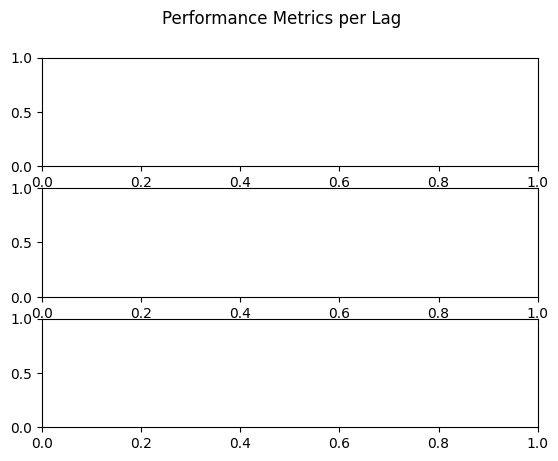

In [116]:
import numpy as np
import matplotlib.pyplot as plt

nbr_days_lag = [i for i in range(60, 195, 15)]

fig, axs = plt.subplots(3)
fig.suptitle('Performance Metrics per Lag')

axs[0].plot(nbr_days_lag, rmse_list, color="red", linestyle='-', label='general')
axs[0].plot(nbr_days_lag, wintertime_rmse_list, color="red", linestyle='--', label='wintertime')
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Lag (in days)')
axs[0].set_xticks(nbr_days_lag)

axs[1].plot(nbr_days_lag, mape_list, color="blue", linestyle='-', label='general')
axs[1].plot(nbr_days_lag, wintertime_mape_list, color="blue", linestyle='--', label='wintertime')
axs[1].set_ylabel('MAPE')
axs[1].set_xlabel('Lag (in days)')
axs[1].set_xticks(nbr_days_lag)

axs[2].plot(nbr_days_lag, corr_list, color="orange", linestyle='-', label='general')
axs[2].plot(nbr_days_lag, wintertime_corr_list, color="orange", linestyle='--', label='wintertime')
axs[2].set_ylabel('PCC')
axs[2].set_xlabel('Lag (in days)')
axs[2].set_xticks(nbr_days_lag)

from matplotlib.lines import Line2D

general_line = Line2D([0], [0], color='black', linestyle='-')
wintertime_line = Line2D([0], [0], color='black', linestyle='--')

fig.legend([general_line, wintertime_line], ['general', 'wintertime'], loc='upper right', fontsize='small')

plt.subplots_adjust(hspace=0.8, top=0.9)

plt.show()

# Visualizations

In [117]:
df = read_processed_data()
df['datetime'] = pd.to_datetime(df['datetime'])

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_additive = seasonal_decompose(df['loadConsumption'], model='multiplicative', period=365*24)
decomposition_additive.plot()
plt.show()

KeyError: 'loadConsumption'

KeyError: 'loadConsumption'

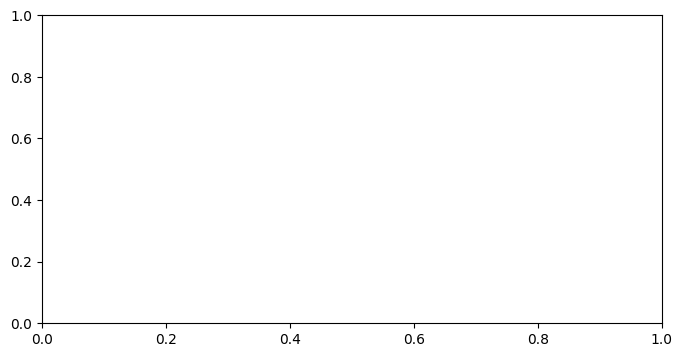

In [119]:
df.set_index('datetime', inplace=True)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df.index, df['loadConsumption'], label='Hourly')
# plt.plot(df['loadConsumption'].resample('D').mean())
plt.plot(df['loadConsumption'].resample('M').mean(), label='Monthly average', color='orange', linewidth=3)

plt.title("Hourly v.s. Average Monthly Load Consumption")
plt.xlabel("Date")
plt.ylabel("Load Consumption")
plt.legend()
plt.grid()
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS'), rotation=45)
plt.show()

KeyError: 'loadConsumption'

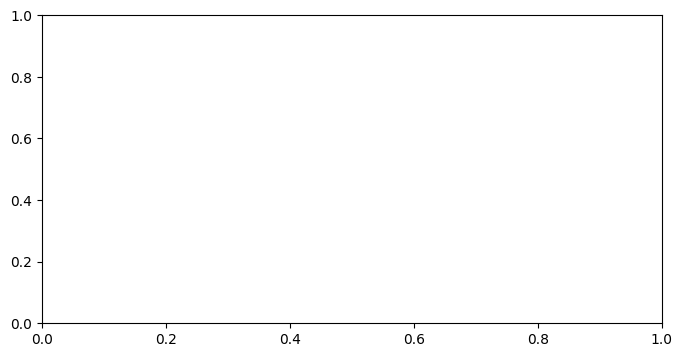

In [120]:
df.reset_index(inplace=True)
single_month = df[(df['datetime'] >= '2010-01-01') & (df['datetime'] <= '2010-01-31')]
single_month.reset_index(inplace=True, drop=True)
single_month.sort_values('datetime', inplace=True)
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(single_month['datetime'], single_month['loadConsumption'])

plt.title("Load Consumption of a Single Month")
plt.xlabel("Date")
plt.ylabel("Load Consumption")
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [121]:
df = read_processed_data()
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour

hourly_avg = df.groupby('hour')['loadConsumption'].mean()

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(hourly_avg.index, hourly_avg.values)

plt.title("Average Hourly Load Consumption")
plt.xlabel("Hour")
plt.ylabel("Load Consumption")
plt.grid()
plt.xticks([i for i in range(0, 24, 1)])
plt.show()

KeyError: 'Column not found: loadConsumption'

In [122]:
from calendar import month_name

df['year'] = df['datetime'].dt.year
single_year = df[(df['year'] == 2015)]
single_year.sort_values('datetime', inplace=True)

single_year_mean = single_year.groupby('Month')['loadConsumption'].mean()

month_names = [month_name[i] for i in single_year_mean.index]

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(month_names, single_year_mean.values)

plt.title("Monthly Average Load Consumption of a Single Year")
plt.xlabel("Month")
plt.ylabel("Load Consumption")
plt.grid()
plt.xticks(rotation=45)

plt.show()

KeyError: 'Column not found: loadConsumption'